# MAGICC7

Pymagicc is also MAGICC7 compatible. 

As yet, the binary is not yet publicly available to it's a bit fiddlier to get setup. Here we give a minimal working example of how to use MAGICC7 with Pymagicc.

In [1]:
# NBVAL_IGNORE_OUTPUT
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 9

import pandas as pd
import pymagicc
from pymagicc.api import MAGICC6, MAGICC7

from pymagicc import rcp26, rcp45, rcp60, rcp85, scenarios

In [2]:
# set your environment to find your MAGICC binary
%env MAGICC_EXECUTABLE_7=../../magicc/run/magicc

env: MAGICC_EXECUTABLE_7=../../magicc/run/magicc


## The slow, easy way

Use the `pymagicc.run` API. This is super slow as it makes a new copy of the entire `magicc/run` directory for each run.

CalledProcessError: Command '['/var/folders/51/39rg93fj6px6dbbfv24050vr0000gn/T/pymagicc-_snoyc3y/run/magicc']' died with <Signals.SIGSEGV: 11>.

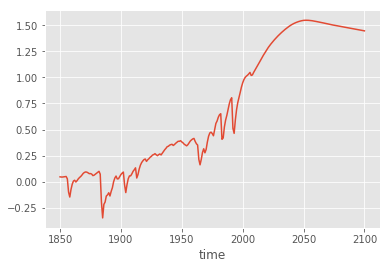

In [3]:
for name, scen in scenarios.items():
    # common gotcha, not getting right output
    results = pymagicc.run(scen, magicc_version=7, out_temperature=1)
    results_df = results.df
    results_df.set_index("time", inplace=True)    

    global_temp_time_rows = (
        (results_df.variable == "Surface Temperature")
        & (results_df.region == "World")
    )
    
    temp = (
        results_df.value[global_temp_time_rows].loc[1850:]
        - results_df.value[global_temp_time_rows].loc[1850:1900].mean()
    )
    temp.plot(label=name)
    
plt.legend()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)");

## The faster, mildly more difficult way

Use the context manager for the MAGICC version we want. This still creates a copy of the entire run folder, but only once.

In [ ]:
with MAGICC7() as magicc:
    for name, scen in scenarios.items():
        # note that we obviously don't need magicc_version as an argument 
        # here
        results = magicc.run(scen, out_temperature=1)
        results_df = results.df
        results_df.set_index("time", inplace=True)    

        global_temp_time_rows = (
            (results_df.variable == "Surface Temperature")
            & (results_df.region == "World")
        )

        temp = (
            results_df.value[global_temp_time_rows].loc[1850:]
            - results_df.value[global_temp_time_rows].loc[1850:1900].mean()
        )
        temp.plot(label=name)

plt.legend()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)");

## The even faster, more dangerous and difficult to debug way

Use the context manager for the MAGICC version we want and specify the root directory. This doesn't create a copy of the entire run folder, but will modify files in place and blow up if any of your settings are not correct.

Common gotchas:

- not clearing `out` directory before running so things are super slow
- pre-existing `MAGTUNE_PYMAGICC.CFG` file with config you don't want to use, or which you want to overwrite (we currently don't do any overwriting with Pymagicc)

In [ ]:
with MAGICC7(root_dir="../../magicc") as magicc:
    # binary readers aren't yet ready and we can't do this through
    # the run method just yet
    magicc.set_output_variables(
        write_ascii=True, write_binary=False, 
        temperature=True, emissions=True,
        parameters=True
    )  
    for name, scen in scenarios.items():
        results = magicc.run(scen)
        results.df = results.df.copy()
        results.df.set_index("time", inplace=True)    

        global_temp_time_rows = (
            (results.df.variable == "Surface Temperature")
            & (results.df.region == "World")
        )

        temp = (
            results.df.value[global_temp_time_rows].loc[1850:]
            - results.df.value[global_temp_time_rows].loc[1850:1900].mean()
        )
        temp.plot(label=name)

plt.legend()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)");

## Comparing MAGICC6 and MAGICC7

Finally, we show how to easily compare MAGICC6 and MAGICC7.

In [ ]:
magicc7_results = []
with MAGICC7(root_dir="../../magicc") as magicc:
    # binary readers aren't yet ready and we can't do this through
    # the run method just yet
    magicc.set_output_variables(
        write_ascii=True, write_binary=False, 
        temperature=True, emissions=True,
        parameters=True
    )  
    for name, scen in scenarios.items():
        results = magicc.run(scen)
        results.df["Climate Model"] = "MAGICC7"
        results.df["Scenario"] = name
        magicc7_results.append(results.df)
        
magicc7_results = pd.concat(magicc7_results)

In [ ]:
magicc6_results = []
with MAGICC6() as magicc:
    # binary readers aren't yet ready and we can't do this through
    # the run method just yet
    magicc.set_output_variables(
        write_ascii=True, write_binary=False, 
        temperature=True, emissions=True,
        parameters=True
    )  
    for name, scen in scenarios.items():
        results = magicc.run(scen)
        results.df["Climate Model"] = "MAGICC6"
        results.df["Scenario"] = name
        magicc6_results.append(results.df)

magicc6_results = pd.concat(magicc6_results)

In [ ]:
results = pd.concat([magicc6_results, magicc7_results])

In [ ]:
results.head()

In [ ]:
magicc7_results.head()